# Face Detection Using Viola-Jones Algorithm 

In [18]:
import numpy as np
from PIL import Image 


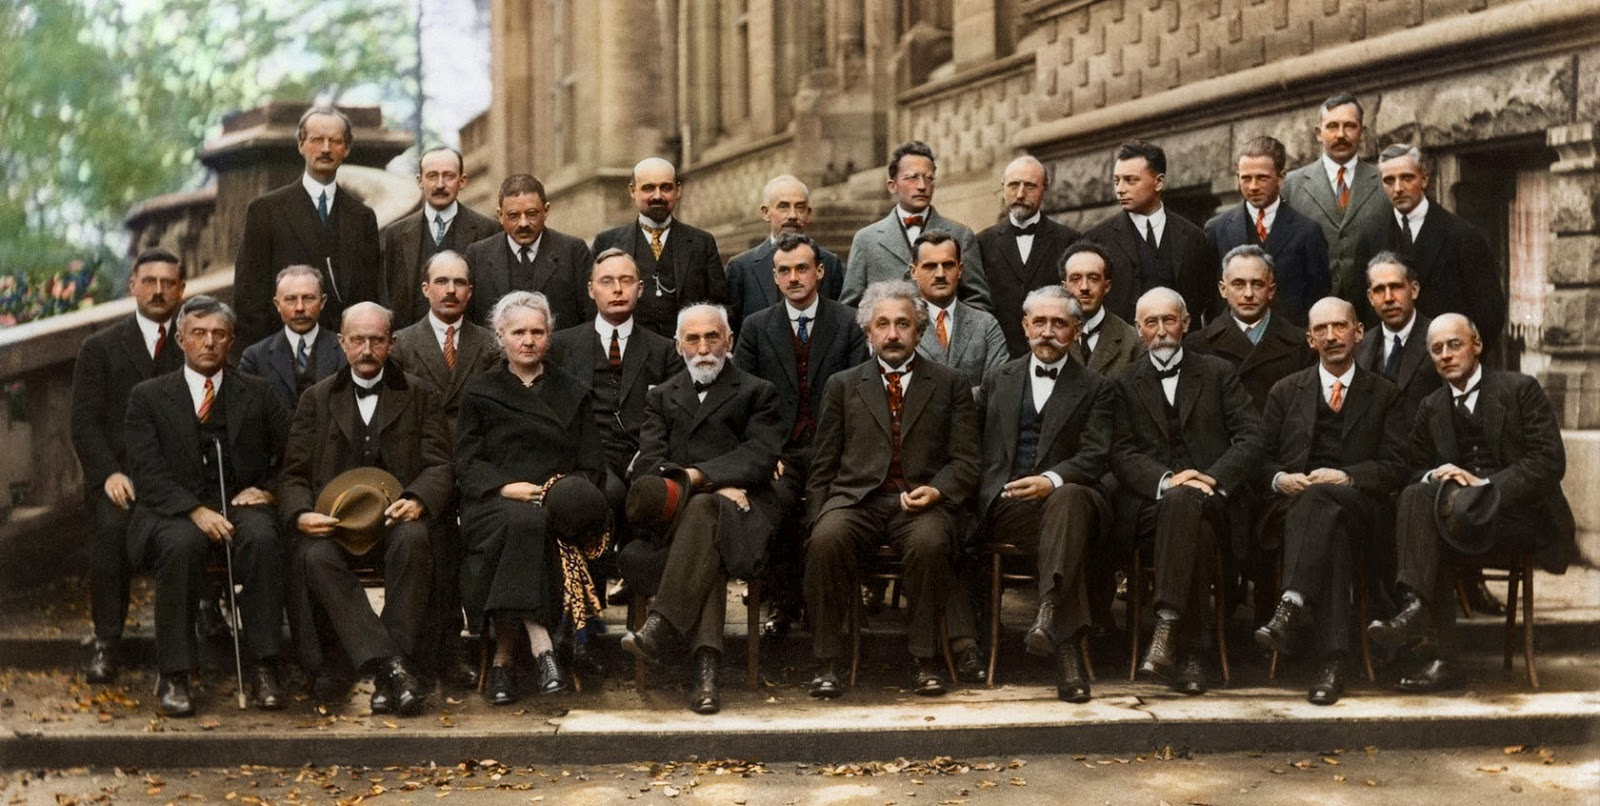

In [6]:
original_image = Image.open("images/solvay-conference.jpg")
original_image

In [7]:
original_image.size # very large image. 

(1600, 806)

I have found this point in the paper of Viola and Jones 
> On
a 700 Mhz Pentium III processor, the face detector can process a 384 by 288 pixel image in about **.067** seconds (using a starting scale of 1.25 and a step size of 1.5 described
below)

In [30]:
def resize_image_object(img, target_size):
    thumbnail_image = img.copy()
    thumbnail_image.thumbnail(target_size, Image.Resampling.LANCZOS)
    return thumbnail_image


(384, 193)


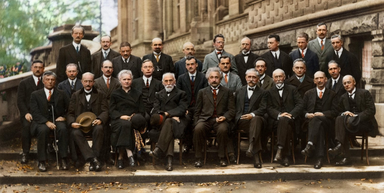

In [39]:
thumbnail_image = resize_image_object(original_image, (384, 288))
print(thumbnail_image.size)
thumbnail_image

In [34]:
def to_float_array(img): 
    return np.array(img).astype(np.float32) / 255.0 # float division 

def to_image(arr):
    return Image.fromarray(np.uint8(arr * 255.0))

In [40]:
original = to_float_array(thumbnail_image)
original.shape

(193, 384, 3)

## Grayscale Conversion 

It turns out that grayscale conversion is important in face recognition, this has been discussed in Kanan and Cottrell 2012 Paper [Color-to-Grayscale: Does the Method Matter in Image Recognition?](http://tdlc.ucsd.edu/SV2013/Kanan_Cottrell_PLOS_Color_2012.pdf) ([DOI](https://doi.org/10.1371/journal.pone.0029740)). 

This conversion is very simple, but not the optimal. 
$$
\mathcal{G}_{Intensity} \leftarrow \frac{1}{3}\left(R + G + B\right),
$$


This conversion considers the eye sensitivity to diffferent colors, but indeed it's not as powerful as it is in face detection 

$$
\mathcal{G}_{\text{Intensity}} \leftarrow (R \times 0.2989 + G \times 0.5870 + B \times 0.1140),
$$


Gleam converions is the optimal, it uses gamma corrected channels

$$
\mathcal{G}_{Gleam} \leftarrow \frac{1}{3}\left(R' + G' + B'\right)
$$
Where 

$$
t' = \Gamma(t) = t^{1/2.2}.
$$

In [47]:
def gamma(channel, coeff = 2.2):
    return channel**(1./coeff)

def gleam_converion(img):
    return np.sum(gamma(img), axis=2) / img.shape[2] # divide by 3 

0.0 0.98680234


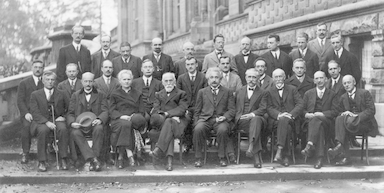

In [52]:
grayscale_image = gleam_converion(original)
print(grayscale_image.min(), grayscale_image.max())
to_image(grayscale_image)

## Features (Haar-like Features) 

Viola and Jones have defined four base Haar-like features; two two-rectangle features, one three-rectangle one and four-rectangle features. They can be understood as follows:

$$
\begin{align}
\mathcal{F}_{2,h} &= \begin{bmatrix}
    1 & -1
    \end{bmatrix} \\
\mathcal{F}_{2,v} &= \begin{bmatrix}
    -1 \\ 1
    \end{bmatrix} \\
\mathcal{F}_{3,h} &= \begin{bmatrix}
    -1 & 1 & -1
    \end{bmatrix} \\
\mathcal{F}_{4} &= \begin{bmatrix}
    1 & -1 \\
    -1 & 1
\end{bmatrix} 
\end{align}.
$$

![Example Image](images\haar_like_featrures.png)

There is another Haar-like feature proposed, which is: 


$$
\begin{align}
\mathcal{F}_{3,v} &= \begin{bmatrix}
    -1 \\ 1 \\ -1
    \end{bmatrix}
\end{align}.
$$


The technique relies upon placing a subframe (window) of $24 \times 24$ pixels within an image, and subsequently placing these 5 rectangular features inside it in every position with every size possible.

In [58]:
WINDOW_SIZE = 24 # as stated in the paper 